<a href="https://colab.research.google.com/github/mika-okamoto/neural-network/blob/main/deep_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
import seaborn as sns

In [129]:
class Layer:

  def __init__(self, output_units, input_units, activation, initialization = 'He'):

    if initialization == 'He':
      self.weights = np.random.randn(output_units, input_units) / np.sqrt(input_units)
    
    if initialization == 'Random':
      self.weights = np.random.randn(output_units, input_units) * 0.01

    self.biases = np.zeros((output_units, 1))

    self.activation = activation
  
  def sigmoid(self, Z):
    return (1 / (1 + np.exp(-Z)))

  def relu(self, Z):
    return np.maximum(0, Z)
  
  def tanh(self, Z):
    return np.tanh(Z)

  
  # Computes derivatives of activation functions.
  def activation_backwards(self, dA):

    if self.activation == 'sigmoid':
      sigmoid_grad = 1.0 * (self.Z >= 0)
      dZ = dA * sigmoid_grad
      return dZ

    if self.activation == 'relu':
      relu_grad = 1.0 * (self.Z >= 0)
      dZ = dA * relu_grad
      return dZ
    
    if self.activation == 'tanh':
      tanh_grad = 1.0 * (self.Z >= 0)
      dZ = dA * tanh_grad
      return dZ
  
  def forward(self):
    pass
  
  def backward(self):
    pass
  
  def update(self):
    pass

In [130]:
layer = Layer(5, 10, "relu")

print ("Weights: \n", layer.weights)
print ("Biases: \n", layer.biases)

Weights: 
 [[-0.04768414  0.03378105 -0.17036345 -0.01294407  0.35290586  0.65280857
   0.02989471 -0.64423278  0.0946651  -0.12045942]
 [-0.29506647  0.04921839 -0.11578946 -0.02978533 -0.64957015 -0.06369244
   0.32779859 -0.50786637  0.5013082   0.23020245]
 [ 0.02896071  0.04570239 -0.47925944 -0.04775554  0.45038801  0.26129542
  -0.04599688  0.25003921 -0.04234745  0.05134782]
 [ 0.18247441  0.12408744  0.77333748  0.24412079  0.13061975 -0.02732743
   0.04332577 -0.31011217  0.030534    0.32401677]
 [-0.17118881 -0.1743284   0.74374817 -0.07650115 -0.07711849 -0.4069885
   0.24821011  0.20410007  0.48995366 -0.20865156]]
Biases: 
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [131]:
class Dense(Layer):

  def __init__(self, output_units, input_units, activation, initialization = 'He'):
    super().__init__(output_units, input_units, activation, initialization)

  # Forward step for a single layer.
  def forward(self, input):
    self.input = input
    Z = np.dot(self.weights, self.input) + self.biases
    self.Z = Z

    # sigmoid activation
    if self.activation == "sigmoid":
      A = self.sigmoid(Z)

    # relu activation
    elif self.activation == "relu":
      A = self.relu(Z)
    
    # tanh activation
    if self.activation == 'tanh':
      A = self.tanh(Z)
    
    # print("PAIN", 1/(1 + np.exp(-Z)))
    # self.A = 1 / (1 + np.exp(-Z))
    self.A = A

    # print('Z', self.Z)
    # print('weights', self.weights)
    # print('a', self.A)
    # print('b', self.biases)
    
    assert (self.Z.shape == (self.weights.shape[0], self.A.shape[1]))
    assert (self.A.shape == (self.weights.shape[0], self.input.shape[1]))

    return self.A

  # Backward step for a single layer.
  def backward(self, dA_prev):
 
    dZ = self.activation_backwards(dA_prev)
    m = self.input.shape[1]
    # print(dZ)
    # print(self.input)
    self.dW = np.dot(dZ, self.input.T) / m
    self.db = sum(sum(dZ)) / m
    # self.db = np.reshape(self.db, (self.db.shape[0], 1)) 
    dA_prev = np.dot(self.weights.T, dZ)

    assert (dA_prev.shape == self.input.shape)
    assert (self.dW.shape == self.weights.shape)

    return dA_prev

  # Parameter update for a single layer.
  def update(self, learning_rate):
    self.weights = self.weights - learning_rate * self.dW
    self.biases = self.biases - learning_rate * self.db

  #Accessor method for weights (self.weights)
  def getWeights(self):
    return self.weights

  #Accessor method for biases (self.biases)
  def getBiases(self):
    return self.biases


In [132]:
class Model:

  def __init__(self):
    self.epsilon = 1e-8

  def build(self, network):
    self.network = network

  # Forward propagation.
  def feedforward(self, X):

    input = X

    for layer in self.network:
      input = layer.forward(input)
    
    AL = input

    assert (AL.shape == (1, X.shape[1]))
    return AL

  def compute_cost(self, m, AL, Y):

    cost = (-1/m) * (np.sum(Y*np.log(AL + 1e-8) + (1-Y) * (np.log(1-AL + 1e-8))))
    cost = np.squeeze(cost)

    return cost

  # Backpropagate through layers.
  def backpropagation(self, dAL):

    dA_prev = dAL

    for i in range(len(self.network) - 1, -1, -1):
      dA_prev = self.network[i].backward(dA_prev)

  # Parameter update.
  def parameter_update(self, learning_rate):

    # Loop over layers and call the update method from each.
    for layer in self.network:
      layer.update(learning_rate)

  # Single iteration of descent.
  def train(self, X, Y, learning_rate):
    # print('X', X)
    # print('Y', Y)

    m = X.shape[1]

    AL = self.feedforward(X)

    cost = self.compute_cost(m, AL, Y)

    Y = Y.reshape(AL.shape)

    dAL = - (np.divide(Y, (AL + 1e-8)) - np.divide(1 - Y, (1 - AL + 1e-8)))

    self.backpropagation(dAL)

    self.parameter_update(learning_rate)
    
    return cost


  # training loop
  def fit(self, X_train, Y_train, epochs, learning_rate):

    # Initialize list of costs.
    costs = []

    # Loop over epochs.
    for i in range(epochs):

      # Call the train method and append the cost to the list.
      cost = self.train(X_train, Y_train, learning_rate)
      costs.append(cost)

    return costs

  # Predict labels.
  def predict(self, X):

    predictions = self.feedforward(X)
    predictions = np.round(predictions)
    return predictions

  # Evaluate prediction accuracy.
  def evaluate(self, predictions, Y):
    accuracy = (1 - abs(np.mean(predictions - Y))) * 100
    return accuracy

In [133]:
def plot(costs):

  plt.plot(costs)
  plt.xlabel('Epochs')
  plt.ylabel('Cost')

  return plt

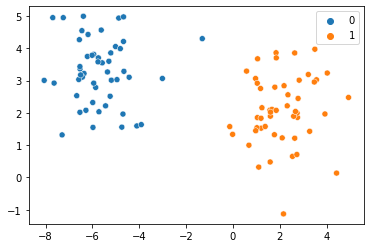

In [134]:
# Generate test data
from sklearn.datasets._samples_generator import make_blobs
from sklearn.model_selection import train_test_split
data, blob = make_blobs(n_samples=100, centers=2, cluster_std=1)
sns.scatterplot(x=data.T[0], y=data.T[1], hue=blob)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(data, blob)
y_train, y_test = y_train.reshape(1, 75), y_test.reshape(1, 25)
X_train, X_test = X_train.reshape(2, 75), X_test.reshape(2, 25)

In [135]:
model = Model()
L1 = Dense(2, 2, 'tanh')
Lout = Dense(1, 2, 'sigmoid')

model.build([L1, Lout])

costs = model.fit(X_train, y_train, 2500, 0.005)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

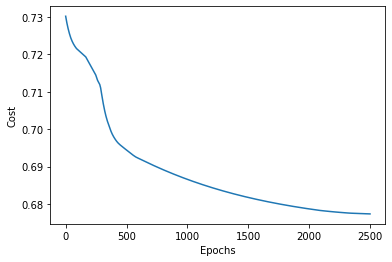

In [136]:
plot(costs)

In [137]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)
print("Train Accuracy", model.evaluate(predictions_train, y_train))
print("Test Accuracy", model.evaluate(predictions_test, y_test))

Train Accuracy 93.33333333333333
Test Accuracy 88.0
